<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Авторы материала: Лисицын Сергей, Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 9. Разреженные данные, онлайн-обучение</center>

## <center>Тьториал и практика по Vowpal Wabbit</center>

**План:**
- **Тьюториал по Vowpal Wabbit. Письма. Бинарная классификация**
- **Тьюториал по Vowpal Wabbit. Письма. Многоклассовая классификация**
- **Тьюториал по Vowpal Wabbit. Рецензии к фильмам IMDB**
- **Применение Vowpal Wabbit к данным по посещению сайтов**

# Тьюториал по Vowpal Wabbit. Новости. Бинарная классификация

Vowpal Wabbit (VW) является одной из наиболее широко используемых библиотек в индустрии. Её отличает высокая скорость работы и поддержка большого количества различных режимов обучения. Особый интерес для больших и высокоразмерных данных представляет онлайн-обучение – самая сильная сторона библиотеки. 


Основным интерфейсом для работы с VW является shell.

In [1]:
import os
import re
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%pylab inline
import sklearn.datasets
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


Для того, чтобы изучить возможные режимы работы vw воспользуемся командой ! для запуска:

In [2]:
!vw --help

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all 

Vowpal Wabbit считывает данные из файла или стандартного ввода (stdin) в формате, который имеет следующий вид:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]`

`Features=(String[:Value] )*`

где [] обозначает необязательные элементы, а (...)\* означает повтор неопределенное число раз. 

- **Label** является числом, "правильным" ответом. В случае классификации обычно принимает значение 1/-1, а в случае регрессии некоторое вещественное число
- **Importance** является числом и отвечает за вес примера при обучении. Это позволяет бороться с проблемой несбалансированных данных, изученной нами ранее
- **Tag** является некоторой строкой без пробелов и отвечает за некоторое "название" примера, которое сохраняется при предсказании ответа. Для того, чтобы отделить Tag от Importance лучше начинать Tag с символа '.
- **Namespace** служит для создания отдельных пространств признаков. В аргументах Namespace именуются по первой букве, это нужно учитывать при выборе их названий
- **Features** являются непосредственно признаками объекта внутри **Namespace**. Признаки по умолчанию имеют вес 1.0, но его можно переопределить, к примеру feature:0.1. 


К примеру, под такой формат подходит следующая строка:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```


чтобы убедиться в этом, запустим vw с этим обучающим примером:

In [3]:
! echo '1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park' | vw

For more information use: vw --help
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
1.000000   1.000000            1         1.0   1.0000   0.0000       10

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1
weighted label sum = 1
average loss = 1
best constant = 1
total feature number = 10


VW является прекрасным инструментом для работы с текстовыми данными. Убедимся в этом с помощью выборки 20newsgroups, содержащей письма из 20 различных тематических рассылок:

In [4]:
newsgroups = sklearn.datasets.fetch_20newsgroups('news_data/')

In [5]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Рассмотрим первый текстовый документ этой коллекции:

In [6]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


**Приведем данные к формату Vowpal Wabbit, при этом оставляя только слова не короче 3 символов. Здесь мы не выполняем многие важные в анализе текстов процедуры (стемминг и лемматизацию), но, как увидим, задача и так будет решаться хорошо.**

In [7]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

Разобьем выборку на обучающую и тестовую и запишем в файл преобразованные таким образом документы. Будем считать документ положительным, если он относится к рассылке про автомобили **rec.autos**. Так мы построим модель, отличающую письма про автомобили от остальных: 

In [8]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
               else -1 for target in newsgroups['target']]

In [9]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)
    
with open('news_data/20news_train.vw', 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open('news_data/20news_test.vw', 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Запустим Vowpal Wabbit на сформированном файле. Мы решаем задачу классификации, поэтому зададим функцию потерь в значение hinge (линейный SVM). Построенную модель мы сохраним в соответствующий файл 20news_model.vw:

In [10]:
!vw -d news_data/20news_train.vw --loss_function hinge -f news_data/20news_model.vw

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
final_regressor = news_data/20news_model.vw
using no cache
Reading datafile = news_data/20news_train.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
1.000000   1.000000            1         1.0  -1.0000   0.0000      157
0.911276   0.822551            2         2.0  -1.0000  -0.1774      159
0.605793   0.300311            4         4.0  -1.0000  -0.3994       92
0.419594   0.233394            8         8.0  -1.0000  -0.8167      129
0.313998   0.208402           16        16.0  -1.0000  -0.6509      108
0.196014   0.078029           32        32.0  -1.0000  -1.0000      115
0.183158   0.170302           64        64.0  -1.0000  -0.7072      114
0.261046   0.338935          128       128.0   1.0000  -0.7900      110
0.261850   0.262653          256       256.0  -1.0000  -0.6557       44
0.216625   0.171401

Модель обучена. VW выводит достаточно много полезной информации по ходу обучения. Обратите внимание, что average loss снижался по ходу выполнения итераций. Для вычисления функции потерь VW использует еще не просмотренные примеры, поэтому, как правило, эта оценка является корректной. Применим обученную модель на тестовой выборке, сохраняя предсказания в файл с помощью опции -p: 

In [11]:
!vw -i news_data/20news_model.vw -t -d news_data/20news_test.vw \
-p news_data/20news_test_predictions.txt

only testing
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = news_data/20news_test_predictions.txt
using no cache
Reading datafile = news_data/20news_test.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
0.000000   0.000000            1         1.0  unknown   1.0000      349
0.000000   0.000000            2         2.0  unknown  -1.0000       50
0.000000   0.000000            4         4.0  unknown  -1.0000      251
0.000000   0.000000            8         8.0  unknown  -1.0000      237
0.000000   0.000000           16        16.0  unknown  -0.9200      106
0.000000   0.000000           32        32.0  unknown  -1.0000      964
0.000000   0.000000           64        64.0  unknown  -1.0000      261
0.000000   0.000000          128       128.0  unknown   0.8358       82
0.000000   0.000000          256       256.0  unknown  -1.0000      186


Загрузим полученные предсказания, вычислим AUC и отобразим ROC-кривую:

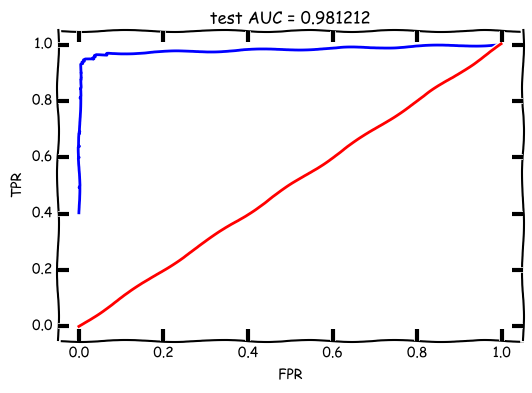

In [12]:
with open('news_data/20news_test_predictions.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = sklearn.metrics.roc_auc_score(test_labels, test_prediction)
roc_curve = sklearn.metrics.roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

Полученное значения AUC говорит о высоком качестве классификации.

# Тьюториал по Vowpal Wabbit. Новости. Многоклассовая классификация

**Используем ту же выборку, что в прошлой части , но решаем задачу многоклассовой классификации. Тут Vowpal Wabbit слегка капризничает – он любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 20). Поэтому придется применить LabelEncoder, да еще и +1 потом добавить (LabelEncoder переводит метки в диапозон от 0 до K-1).**

In [13]:
all_documents = newsgroups['data']
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups['target']) + 1

**Выборки будут те же, а метки поменяются, train_labels_mult и test_labels_mult – векторы меток от 1 до 20.**

In [14]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=7)

In [15]:
with open('news_data/20news_train_mult.vw', 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with open('news_data/20news_test_mult.vw', 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

**Обучим Vowpal Wabbit в режиме многоклассовой классификации, передав параметр *oaa* (от "one against all"), равный числу классов. Также перечислим параметры, которые можно понастраивать, и от которых качество модели может довольно значительно зависеть (более полно – в официальном [тьюториале](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial) по Vowpal Wabbit):**
 - темп обучения (-l, по умолчанию 0.5) – коэффициент перед изменением весов модели при каждом изменении
 - степень убывания темпа обучения (--power_t, по умолчанию 0.5) – на практике проверено, что если темп обучения уменьшается при увеличении числа итераций стохастического градиентного спуска, то минимум функции находится лучше 
 - функция потерь (--loss_function) – от нее, по сути, зависит обучаемый алгоритм
 - регуляризация (-l1) – тут надо обратить внимание на то, что в VW регуляризация считается для каждого объекта, поэтому коэффициенты регуляризации обычно берутся малыми, около $10^{-20}.$
 
 **Дополнительно: в соревновании можно попробовать автоматическую настройку параметров Vowpal Wabbit с Hyperopt. Пока это работает только с Python 2. [Статья](https://habrahabr.ru/company/dca/blog/272697/) на Хабре.**

In [16]:
%%time
!vw --oaa 20 news_data/20news_train_mult.vw -f news_data/20news_model_mult.vw \
--loss_function=hinge

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
final_regressor = news_data/20news_model_mult.vw
using no cache
Reading datafile = news_data/20news_train_mult.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
1.000000   1.000000          1      1.0         15        1      157
1.000000   1.000000          2      2.0          2       15      159
1.000000   1.000000          4      4.0         15       10       92
1.000000   1.000000          8      8.0         16       15      129
1.000000   1.000000         16     16.0         13       12      108
0.937500   0.875000         32     32.0          2       12      115
0.906250   0.875000         64     64.0         16       16      114
0.867188   0.828125        128    128.0          8       11      110
0.824219   0.781250        256    256.0          7       15       44
0.650391   0.476562        512    51

In [17]:
%%time
!vw -i news_data/20news_model_mult.vw -t -d news_data/20news_test_mult.vw \
-p news_data/20news_test_predictions_mult.txt

only testing
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = news_data/20news_test_predictions_mult.txt
using no cache
Reading datafile = news_data/20news_test_mult.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
1.000000   1.000000          1      1.0   4294967295        8      349
1.000000   1.000000          2      2.0   4294967295        6       50
1.000000   1.000000          4      4.0   4294967295       18      251
1.000000   1.000000          8      8.0   4294967295       18      237
1.000000   1.000000         16     16.0   4294967295        1      106
1.000000   1.000000         32     32.0   4294967295       15      964
1.000000   1.000000         64     64.0   4294967295        4      261
1.000000   1.000000        128    128.0   4294967295        8       82
1.000000   1.000000        256    256.0   4294967295       10      186

In [18]:
with open('news_data/20news_test_predictions_mult.txt') as pred_file:
    test_prediction_mult = [float(label) 
                             for label in pred_file.readlines()]

In [19]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.87840226228349239

**Выведем раскрашенную матрицу ошибок полученного классификатора. Если понаклонять монитор, можно заметить, какие ошибке чаще совершаются.**

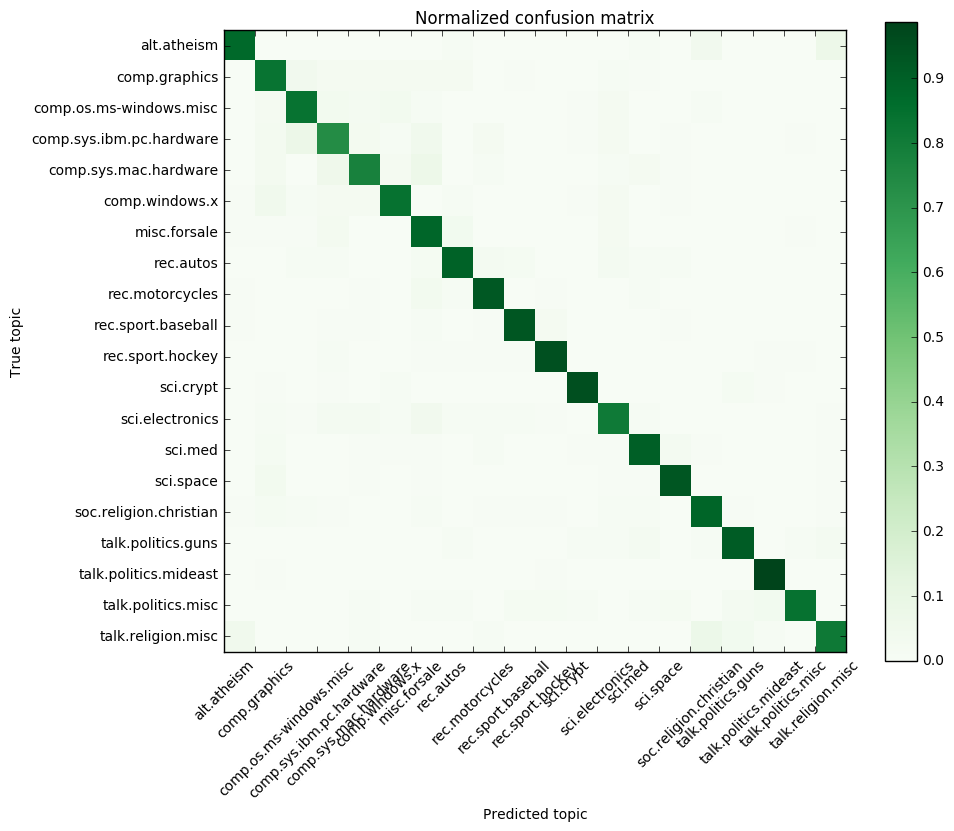

In [22]:
from sklearn.metrics import confusion_matrix

M = confusion_matrix(test_labels_mult, test_prediction_mult)
M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
im = plt.imshow(M_normalized, interpolation='nearest', cmap='Greens')
plt.colorbar(im, shrink=0.71)
tick_marks = np.arange(len(newsgroups['target_names']))
plt.xticks(tick_marks - 0.5, newsgroups['target_names'], rotation=45)
plt.yticks(tick_marks, newsgroups['target_names'])
plt.tight_layout()
plt.ylabel('True topic')
plt.xlabel('Predicted topic')
plt.title('Normalized confusion matrix')
plt.show()

## Часть 3. Тьюториал по Vowpal Wabbit. Рецензии к фильмам IMDB

**В этой части мы будем заниматься бинарной классификацией отзывов к фильмам, публикованным на сайте IMDB. Обратите внимание, насколько быстро будет работать Vowpal Wabbit.**

**Используем функцию *load_files* из sklearn.datasets для загрузки отзывов по фильмам [отсюда](https://yadi.sk/d/Tg1Tflur333iLr). Скачайте данные и положите рядом с этой тетрадкой в каталог *aclImdb* (в нем должны быть каталоги *train* и *test*). Разарживирование может занять несколько минут – там 100 тыс. файлов. В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам. Отделим данные (собственно тексты) от меток.**

In [23]:
from sklearn.datasets import load_files

In [25]:
reviews_train = load_files('aclImdb/train')
text_train, y_train = reviews_train.data, reviews_train.target

In [26]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


То же самое с тестовой выборкой.

In [27]:
reviews_test = load_files('aclImdb/test')
text_test, y_test = reviews_test.data, reviews_train.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Примеры отзывов и соответствующих меток.**

In [28]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [29]:
y_train[0] # хороший отзыв

1

In [30]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [31]:
y_train[1] # плохой отзыв

0

**Будем использовать ранее написанную функцию to_vw_format.**

In [32]:
to_vw_format(str(text_train[1]), 1 if y_train[0] == 1 else -1)

'1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

**Подготовим обучающую (movie_reviews_train.vw), отложенную (movie_reviews_valid.vw) и тестовую (movie_reviews_test.vw) выборки для Vowpal Wabbit. 70% исходной обучаюшей выборки оставим под обучение, 30% – под отложенную выборку.**

In [33]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [34]:
len(train_labels), len(valid_labels)

(17500, 7500)

In [35]:
with open('aclImdb/movie_reviews_train.vw', 'w') as vw_train_data:
    for text, target in zip(train, train_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open('aclImdb/movie_reviews_valid.vw', 'w') as vw_train_data:
    for text, target in zip(valid, valid_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open('aclImdb/movie_reviews_test.vw', 'w') as vw_test_data:
    for text in text_test:
        vw_test_data.write(to_vw_format(str(text)))

In [36]:
!head -2 aclImdb/movie_reviews_train.vw

1 |text zero day leads you think even think why two boys young men would what they did commit mutual suicide via slaughtering their classmates captures what must beyond bizarre mode being for two humans who have decided withdraw from common civility order define their own mutual world via coupled destruction not perfect movie but given what money time the filmmaker and actors had remarkable product terms explaining the motives and actions the two young suicide murderers better than elephant terms being film that gets under our rationalistic skin far far better film than almost anything you are likely see flawed but honest with terrible honesty
-1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regardi

In [37]:
!head -2 aclImdb/movie_reviews_valid.vw

1 |text matter life and death what can you really say that would properly justice the genius and beauty this film powell and pressburger visual imagination knows bounds every frame filled with fantastically bold compositions the switches between the bold colours the real world the stark black and white heaven ingenious showing visually just how much more vibrant life the final court scene also fantastic the judge and jury descend the stairway heaven hold court over peter david niven operation all the performances are spot roger livesey being standout and the romantic energy the film beautiful never has there been more romantic film than this there has haven seen matter life and death all about the power love and just how important life and jack cardiff cinematography reason enough watch the film alone the way lights kim hunter face makes her all the more beautiful what genius can make simple things such game table tennis look exciting and the sound design also impeccable the way the so

In [38]:
!head -2 aclImdb/movie_reviews_test.vw

 |text don hate heather graham because she beautiful hate her because she fun watch this movie like the hip clothing and funky surroundings the actors this flick work well together casey affleck hysterical and heather graham literally lights the screen the minor characters goran visnjic sigh and patricia velazquez are talented they are gorgeous congratulations miramax director lisa krueger
 |text don know how this movie has received many positive comments one can call artistic and beautifully filmed but those things don make for the empty plot that was filled with sexual innuendos wish had not wasted time watch this movie rather than being biographical was poor excuse for promoting strange and lewd behavior was just another hollywood attempt convince that that kind life normal and from the very beginning asked self what was the point this movie and continued watching hoping that would change and was quite disappointed that continued the same vein glad did not spend the money see this t

**Обучим модель Vowpal Wabbit со следующими агрументами:**

 - -d, путь к обучающей выборке (соотв. файл .vw )
 - --loss_function – hinge (хотя можно и поэкспериментировать с другими)
 - -f – путь к файлу, в который запишется модель (можно тоже в формате .vw)

In [39]:
!vw -d aclImdb/movie_reviews_train.vw \
--loss_function hinge -f aclImdb/movie_reviews_model.vw

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
final_regressor = aclImdb/movie_reviews_model.vw
using no cache
Reading datafile = aclImdb/movie_reviews_train.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
1.000000   1.000000            1         1.0   1.0000   0.0000      105
1.324514   1.649029            2         2.0  -1.0000   0.6490      164
1.274999   1.225483            4         4.0  -1.0000   0.2310      110
1.071162   0.867325            8         8.0  -1.0000   0.4609      219
1.063382   1.055602           16        16.0   1.0000  -0.5401      204
0.986123   0.908864           32        32.0   1.0000   0.2250      190
1.016452   1.046781           64        64.0  -1.0000   0.3709      126
0.917579   0.818706          128       128.0  -1.0000  -1.0000      106
0.864022   0.810464          256       256.0  -1.0000  -1.0000       93
0.752708 

**Сделаем прогноз для отложенной выборки с помощью обученной модели Vowpal Wabbit, передав следующие аргументы:**
 - -i –путь к обученной модели (соотв. файл .vw)
 - -t -d – путь к отложенной выборке (соотв. файл .vw)
 - -p – путь к txt-файлу, куда запишутся прогнозы

In [40]:
!vw -i aclImdb/movie_reviews_model.vw -t -d aclImdb/movie_reviews_valid.vw \
-p aclImdb/movie_valid_pred.txt

only testing
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = aclImdb/movie_valid_pred.txt
using no cache
Reading datafile = aclImdb/movie_reviews_valid.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
0.000000   0.000000            1         1.0   1.0000   1.0000      204
0.001057   0.002114            2         2.0   1.0000   0.9540      132
0.000528   0.000000            4         4.0   1.0000   1.0000       97
0.001101   0.001674            8         8.0   1.0000   1.0000      128
0.277359   0.553616           16        16.0   1.0000   0.9065       35
0.297558   0.317757           32        32.0   1.0000   1.0000      268
0.472502   0.647446           64        64.0   1.0000   0.8044       92
0.400564   0.328625          128       128.0   1.0000   1.0000      272
0.386828   0.373092          256       256.0   1.0000   1.0000      430
0.3

**Считаем прогноз из файла и посчитаем долю правильных ответов и ROC AUC. Учтем, что VW выводит оценки вероятности принадлежности к классу +1. Эти оценки распределены на [-1, 1], поэтому бинарным ответом алгоритма (0 или 1) будем попросту считать тот факт, что оценка получилась положительной.**

In [41]:
with open('aclImdb/movie_valid_pred.txt') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.878
AUC: 0.939


**Сделаем то же самое для тестовой выборки.**

In [42]:
!vw -i aclImdb/movie_reviews_model.vw -t -d aclImdb/movie_reviews_test.vw \
-p aclImdb/movie_test_pred.txt

only testing
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = aclImdb/movie_test_pred.txt
using no cache
Reading datafile = aclImdb/movie_reviews_test.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
0.000000   0.000000            1         1.0  unknown   0.1236       59
0.000000   0.000000            2         2.0  unknown  -1.0000      103
0.000000   0.000000            4         4.0  unknown  -1.0000      161
0.000000   0.000000            8         8.0  unknown  -0.8061      365
0.000000   0.000000           16        16.0  unknown   1.0000      319
0.000000   0.000000           32        32.0  unknown   1.0000       95
0.000000   0.000000           64        64.0  unknown  -0.8477      139
0.000000   0.000000          128       128.0  unknown  -0.6414       92
0.000000   0.000000          256       256.0  unknown   0.0318      411
0.000

In [43]:
with open('aclImdb/movie_test_pred.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Accuracy: 0.875
AUC: 0.937


**Попробуем улучшить прогноз за счет задействования биграмм.**

In [44]:
!vw -d aclImdb/movie_reviews_train.vw \
--loss_function hinge --ngram 2 -f aclImdb/movie_reviews_model2.vw

Generating 2-grams for all namespaces.
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
final_regressor = aclImdb/movie_reviews_model2.vw
using no cache
Reading datafile = aclImdb/movie_reviews_train.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
1.000000   1.000000            1         1.0   1.0000   0.0000      208
1.163564   1.327128            2         2.0  -1.0000   0.3271      326
1.132272   1.100979            4         4.0  -1.0000   0.1421      218
1.038996   0.945721            8         8.0  -1.0000  -0.0209      436
1.066398   1.093799           16        16.0   1.0000  -0.3067      406
1.015723   0.965048           32        32.0   1.0000   0.1252      378
0.998651   0.981580           64        64.0  -1.0000   0.1227      250
0.944862   0.891073          128       128.0  -1.0000  -0.5894      210
0.915689   0.886517          256       25

In [45]:
!vw -i aclImdb/movie_reviews_model2.vw -t -d aclImdb/movie_reviews_valid.vw \
-p aclImdb/movie_valid_pred2.txt

Generating 2-grams for all namespaces.
only testing
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = aclImdb/movie_valid_pred2.txt
using no cache
Reading datafile = aclImdb/movie_reviews_valid.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
0.000000   0.000000            1         1.0   1.0000   1.0000      406
0.063806   0.127611            2         2.0   1.0000   0.6428      262
0.031903   0.000000            4         4.0   1.0000   1.0000      192
0.036450   0.040997            8         8.0   1.0000   1.0000      254
0.253452   0.470455           16        16.0   1.0000   0.6028       68
0.275639   0.297826           32        32.0   1.0000   1.0000      534
0.380044   0.484450           64        64.0   1.0000   0.6277      182
0.302507   0.224969          128       128.0   1.0000   0.8659      542
0.348705   0.394903          256   

In [46]:
with open('aclImdb/movie_valid_pred2.txt') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.895
AUC: 0.954


In [48]:
!vw -i aclImdb/movie_reviews_model2.vw -t -d aclImdb/movie_reviews_test.vw \
-p aclImdb/movie_test_pred2.txt

Generating 2-grams for all namespaces.
only testing
Num weight bits = 18
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = aclImdb/movie_test_pred2.txt
using no cache
Reading datafile = aclImdb/movie_reviews_test.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
0.000000   0.000000            1         1.0  unknown  -0.0320      116
0.000000   0.000000            2         2.0  unknown  -1.0000      204
0.000000   0.000000            4         4.0  unknown  -1.0000      320
0.000000   0.000000            8         8.0  unknown  -1.0000      728
0.000000   0.000000           16        16.0  unknown   1.0000      636
0.000000   0.000000           32        32.0  unknown   0.9604      188
0.000000   0.000000           64        64.0  unknown  -0.4092      276
0.000000   0.000000          128       128.0  unknown  -0.8558      182
0.000000   0.000000          256     

In [49]:
with open('aclImdb/movie_test_pred2.txt') as pred_file:
    test_prediction2 = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))

Accuracy: 0.888
AUC: 0.951


Видим, что биграммы помогли повысить качество классификации.

## Часть 4. Применение Vowapl Wabbit к данным по посещению сайтов

**Считайте данные [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can-yandex-mipt/data) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [50]:
train_df = ''' ВАШ КОД ЗДЕСЬ '''
test_df = ''' ВАШ КОД ЗДЕСЬ '''

**Пока в качестве признаков используем только посещенные сайты. Заполните пропуски нулями и переведите данные в разреженный формат – создайте 2 матрицы Scipy.sparse.csr_matrix.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [51]:
train_df_sites = train_df[['site1', 'site2', 'site3', 'site4','site5', 'site6','site7', 'site8',
                         'site9', 'site10']].fillna(0).astype('int')
test_df_sites = test_df[['site1', 'site2', 'site3', 'site4','site5', 'site6','site7', 'site8',
                         'site9', 'site10']].fillna(0).astype('int')

In [52]:
X_train_sparse = ''' ВАШ КОД ЗДЕСЬ '''
X_test_sparse = ''' ВАШ КОД ЗДЕСЬ '''
y = ''' ВАШ КОД ЗДЕСЬ '''

**Vowpal Wabbit любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 550). Поэтому придется применить LabelEncoder, да еще и +1 потом добавить (LabelEncoder переводит метки в диапозон от 0 до K-1).**

In [55]:
class_encoder = ''' ВАШ КОД ЗДЕСЬ '''
y_for_vw = ''' ВАШ КОД ЗДЕСЬ '''

**Выделим обучающую и оставленную части исходной обучающей выборки.**

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, 
                                                     random_state=7, stratify=y)

**Реализуйте функцию, переводящую разреженную матрицу в формат Vowpal Wabbit.**

Вход:
 - X_sparse – разреженная матрица SciPy.sparse.csr_matrix
 - y (необяз.) - вектор ответов. Необязателен, поскольку тестовую матрицу будем обрабатывать этой же функцией
 - out_file – путь к файлу .vw, в который будет произведена запись
 
Детали:
- можно делать по-разному, но скорее всего поможет метод *nonzero* разреженной матрицы
- в тестовой выборке на месте меток целевого класса можно писать произвольные, допустим, 1

In [58]:
def sparse_matrix_to_vw(X_sparse, y=None, out_file='tmp.vw'):
    ''' ВАШ КОД ЗДЕСЬ '''

**Примените написанную функцию к части обучащей выборки (X_train, y_train), к отложенной выборке (X_valid, y_valid), ко всей обучающей выборке (X_train_sparse, y_for_vw) и ко всей тестовой выборке X_test_sparse.**

In [59]:
sparse_matrix_to_vw(X_train, y_train, 'kaggle_data/train_part.vw')

In [60]:
sparse_matrix_to_vw(X_valid, y_valid, 'kaggle_data/valid.vw')

In [61]:
sparse_matrix_to_vw(X_train_sparse, y_for_vw, 'kaggle_data/train.vw')

In [62]:
sparse_matrix_to_vw(X_test_sparse, out_file='kaggle_data/test.vw')

**Обучите модель на выборке kaggle_data/train_part.vw. Укажите, что решается задача классификации с 550 классами (--oaa), сделайте 3 прохода по выборке (--passes), используйте начальный шаг (-l) 0.3 и степень, с которой этот шаг падает 0.8 (--power_t). Наконец, задайте логистическую функцию потерь с l1-регуляризатором $10^{-30}$. Также укажите значение параметра b=26. Это число бит, используемых для хэшерования, в данном случае нужно больше, чем 18 по умолчанию.**

In [66]:
%%time
!vw --oaa 550 ''' ВАШ КОД ЗДЕСЬ '''

using l1 regularization = 1e-30
Num weight bits = 26
learning rate = 0.3
initial_t = 0
power_t = 0.8
decay_learning_rate = 1
final_regressor = kaggle_data/vw_model_part.vw
using cache_file = kaggle_data/train_part.vw.cache
ignoring text input in favor of cache input
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
2.000000   2.000000          2      1.0         67        1        3
1.000000   0.500000          3      3.0         29       67        3
0.666667   0.333333          4      6.0        457       67        9
0.400000   0.222222          6     15.0        542       67        2
0.250000   0.142857          9     36.0         77      457       10
0.158537   0.086957         13     82.0        358       94        6
0.098901   0.050000         19    182.0        220       67       11
0.068783   0.040816         27    378.0         36       67        9
0.048366   0.028424  

**Запишите прогнозы на выборке *kaggle_data/valid.vw* в *kaggle_data/vw_valid_pred.csv*.**

In [67]:
%%time
!vw -t ''' ВАШ КОД ЗДЕСЬ '''

only testing
Num weight bits = 26
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = kaggle_data/vw_valid_pred.csv
using no cache
Reading datafile = kaggle_data/valid.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
1.000000   1.000000          2      1.0        178      178        5
0.666667   0.500000          3      3.0        534      298       10
0.500000   0.333333          4      6.0        160      370        8
0.333333   0.222222          6     15.0        362      267        5
0.194444   0.095238          9     36.0        547      547        6
0.141026   0.095238         13     78.0        356      547        7
0.087719   0.043011         19    171.0        252       94        2
0.059829   0.033333         27    351.0        533      533        9
0.041252   0.022727         38    703.0         41      539       10
0.030049   0.019231         54   1431.0

**Считайте прогнозы *kaggle_data/vw_valid_pred.csv*  из файла и посмотрите на долю правильных ответов на отложенной части.**

In [68]:
vw_valid_pred = pd.read_csv ''' ВАШ КОД ЗДЕСЬ '''
accuracy_score ''' ВАШ КОД ЗДЕСЬ '''

0.27682193313750175

**Обучите модель с теми же параметрами на всей обучающей выборке – *kaggle_data/train.vw*.**

In [69]:
%%time
!vw --oaa 550 ''' ВАШ КОД ЗДЕСЬ '''

using l1 regularization = 1e-30
Num weight bits = 26
learning rate = 0.3
initial_t = 0
power_t = 0.8
decay_learning_rate = 1
final_regressor = kaggle_data/vw_model.vw
using cache_file = kaggle_data/train.vw.cache
ignoring text input in favor of cache input
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
2.000000   2.000000          2      1.0        135        1       11
1.000000   0.500000          3      3.0        330      135       11
0.666667   0.333333          4      6.0        407      135       11
0.400000   0.222222          6     15.0        255      407       11
0.250000   0.142857          9     36.0        358      135       11
0.158537   0.086957         13     82.0         77      135        2
0.104396   0.060000         19    182.0        169      255       11
0.071429   0.040816         27    378.0         83      358       11
0.049673   0.028424         38 

**Сделайте прогноз для тестовой выборки.**

In [75]:
%%time
!vw -t ''' ВАШ КОД ЗДЕСЬ '''

only testing
Num weight bits = 26
learning rate = 10
initial_t = 1
power_t = 0.5
predictions = kaggle_data/vw_pred.csv
using no cache
Reading datafile = kaggle_data/test.vw
num sources = 1
average    since         example     example  current  current  current
loss       last          counter      weight    label  predict features
2.000000   2.000000          2      1.0          1      430       11
1.000000   0.500000          3      3.0          1       85       11
0.666667   0.333333          4      6.0          1      108       11
0.400000   0.222222          6     15.0          1      128       11
0.250000   0.142857          9     36.0          1      161       11
0.166667   0.095238         13     78.0          1       86       11
0.111111   0.064516         19    171.0          1      512        2
0.076923   0.044444         27    351.0          1      457       11
0.054054   0.031250         38    703.0          1       77       11
0.037736   0.021978         54   1431.0       

**Запишите прогноз в файл, примените обратное преобразование меток (был LabelEncoder и потом +1 в меткам) и отправьте решение на Kaggle.**

In [76]:
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Прогноз, считанный из файла:

In [77]:
vw_pred = ''' ВАШ КОД ЗДЕСЬ '''

Прогноз для отправки на Kaggle:

In [78]:
vw_subm = class_encoder.inverse_transform ''' ВАШ КОД ЗДЕСЬ '''

In [79]:
write_to_submission_file(vw_subm,
                         'kaggle_data/first_vw_submission.csv')

**Полученный результат соответствует бейзлайну "Vowpal Wabbit" на публичном лидерборде в нашем соревновании Kaggle.**